In [78]:
# import modules
import pandas as pd
from scraper import config
import numpy as np
import sqlalchemy as sqla
import pickle
from sqlalchemy import create_engine

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [79]:
# establish connection with database using sqlalchemy
engine = create_engine(config.DB_URL, echo=True)

In [80]:
# get availability table from db
df_availability = pd.read_sql_table("Availability", engine)

2023-04-15 13:21:00,702 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-04-15 13:21:00,706 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-15 13:21:00,904 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-04-15 13:21:00,907 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-15 13:21:01,007 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-04-15 13:21:01,009 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-15 13:21:01,306 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %s AND table_name = %s
2023-04-15 13:21:01,309 INFO sqlalchemy.engine.Engine [generated in 0.00364s] ('dublinbikes', 'Availability')
2023-04-15 13:21:01,616 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `Availability`
2023-04-15 13:21:01,619 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-15 13:21:01,829 INFO sqlalchemy.engine.Engine SELECT `Availability`.number, `Availability`.last_update, `Availability`.available_bikes, `Availability`.a

In [81]:
df_availability

,number,last_update,available_bikes,available_bike_stands,status,scraping_date
0,1,1678113464000,27,4,OPEN,1678113902
1,1,1678114176000,27,4,OPEN,1678114202
2,1,1678114234000,27,4,OPEN,1678114502
3,1,1678114234000,27,4,OPEN,1678114803
4,1,1678114973000,27,4,OPEN,1678115102
...,...,...,...,...,...,...
1174537,117,1681559862000,2,38,OPEN,1681560005
1174538,117,1681559862000,2,38,OPEN,1681560302
1174539,117,1681560466000,2,38,OPEN,1681560602
1174540,117,1681560888000,1,39,OPEN,1681560902


In [82]:
# scraping_date & status columns are not required for modeling, so will be dropped
df_availability.drop(['status','scraping_date'], axis=1, inplace=True)

In [83]:
df_availability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174542 entries, 0 to 1174541
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype
---  ------                 --------------    -----
 0   number                 1174542 non-null  int64
 1   last_update            1174542 non-null  int64
 2   available_bikes        1174542 non-null  int64
 3   available_bike_stands  1174542 non-null  int64
dtypes: int64(4)
memory usage: 35.8 MB


In [84]:
# look for duplicates
print('Number of duplicate (excluding first) rows in the table is: ', df_availability.duplicated().sum())

# use "keep=False" to mark all duplicates as true, including the original rows that were duplicated
print('Number of duplicate rows (including first) in the table is:', df_availability[df_availability.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  485210
Number of duplicate rows (including first) in the table is: 960043


In [85]:
df_availability = df_availability.drop_duplicates()

In [86]:
# check rows after removing duplicates
print('Number of duplicate (excluding first) rows in the table is: ', df_availability.duplicated().sum())
df_availability

Number of duplicate (excluding first) rows in the table is:  0


,number,last_update,available_bikes,available_bike_stands
0,1,1678113464000,27,4
1,1,1678114176000,27,4
2,1,1678114234000,27,4
4,1,1678114973000,27,4
6,1,1678115578000,27,4
...,...,...,...,...
1174535,117,1681559257000,2,38
1174537,117,1681559862000,2,38
1174539,117,1681560466000,2,38
1174540,117,1681560888000,1,39


In [87]:
# convert last_update to date-time
df_availability['last_update'] = pd.to_datetime(df_availability['last_update'], unit='ms')

In [88]:
df_availability

,number,last_update,available_bikes,available_bike_stands
0,1,2023-03-06 14:37:44,27,4
1,1,2023-03-06 14:49:36,27,4
2,1,2023-03-06 14:50:34,27,4
4,1,2023-03-06 15:02:53,27,4
6,1,2023-03-06 15:12:58,27,4
...,...,...,...,...
1174535,117,2023-04-15 11:47:37,2,38
1174537,117,2023-04-15 11:57:42,2,38
1174539,117,2023-04-15 12:07:46,2,38
1174540,117,2023-04-15 12:14:48,1,39


In [89]:
df_availability['time'] = df_availability['last_update'].dt.strftime('%Y-%m-%d %H')
df_availability['hour'] = df_availability['last_update'].dt.strftime('%H')
df_availability['weekday']= df_availability['last_update'].dt.weekday
df_availability

,number,last_update,available_bikes,available_bike_stands,time,hour,weekday
0,1,2023-03-06 14:37:44,27,4,2023-03-06 14,14,0
1,1,2023-03-06 14:49:36,27,4,2023-03-06 14,14,0
2,1,2023-03-06 14:50:34,27,4,2023-03-06 14,14,0
4,1,2023-03-06 15:02:53,27,4,2023-03-06 15,15,0
6,1,2023-03-06 15:12:58,27,4,2023-03-06 15,15,0
...,...,...,...,...,...,...,...
1174535,117,2023-04-15 11:47:37,2,38,2023-04-15 11,11,5
1174537,117,2023-04-15 11:57:42,2,38,2023-04-15 11,11,5
1174539,117,2023-04-15 12:07:46,2,38,2023-04-15 12,12,5
1174540,117,2023-04-15 12:14:48,1,39,2023-04-15 12,12,5


In [90]:
 df_availability['weekday'].value_counts()

1    119108
2    114689
0    101431
3     99780
4     97513
5     82993
6     73818
Name: weekday, dtype: int64

In [91]:
hour_mean = df_availability.groupby(['number','time','hour','weekday'])['available_bikes','available_bike_stands'].mean()
print(hour_mean)

                                   available_bikes  available_bike_stands
number time          hour weekday                                        
1      2023-03-06 14 14   0              27.000000               4.000000
       2023-03-06 15 15   0              26.000000               5.000000
       2023-03-06 16 16   0              24.285714               6.714286
       2023-03-06 17 17   0              22.428571               8.571429
       2023-03-06 18 18   0              20.000000              11.000000
...                                            ...                    ...
117    2023-04-15 08 08   5               3.000000              37.000000
       2023-04-15 09 09   5               2.333333              37.666667
       2023-04-15 10 10   5               2.000000              38.000000
       2023-04-15 11 11   5               2.000000              38.000000
       2023-04-15 12 12   5               1.333333              38.666667

[98071 rows x 2 columns]


In [92]:
df_hourinfo = pd.DataFrame(hour_mean.to_records())
df_hourinfo

,number,time,hour,weekday,available_bikes,available_bike_stands
0,1,2023-03-06 14,14,0,27.000000,4.000000
1,1,2023-03-06 15,15,0,26.000000,5.000000
2,1,2023-03-06 16,16,0,24.285714,6.714286
3,1,2023-03-06 17,17,0,22.428571,8.571429
4,1,2023-03-06 18,18,0,20.000000,11.000000
...,...,...,...,...,...,...
98066,117,2023-04-15 08,08,5,3.000000,37.000000
98067,117,2023-04-15 09,09,5,2.333333,37.666667
98068,117,2023-04-15 10,10,5,2.000000,38.000000
98069,117,2023-04-15 11,11,5,2.000000,38.000000


In [93]:
# save cleaned dataframe in csv file
df_hourinfo.to_csv('bikes_hourinfo.csv', index=False)

### Weather

In [94]:
# get weather table from db
df_weather = pd.read_sql_table("weather", engine)

2023-04-15 13:21:14,540 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %s AND table_name = %s
2023-04-15 13:21:14,541 INFO sqlalchemy.engine.Engine [cached since 13.24s ago] ('dublinbikes', 'weather')
2023-04-15 13:21:14,844 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `weather`
2023-04-15 13:21:14,846 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-15 13:21:15,050 INFO sqlalchemy.engine.Engine SELECT weather.time_scrape, weather.time_api_update, weather.weather_id, weather.weather_info, weather.wind_speed, weather.temperature 
FROM weather
2023-04-15 13:21:15,052 INFO sqlalchemy.engine.Engine [generated in 0.00193s] ()


In [95]:
df_weather

,time_scrape,time_api_update,weather_id,weather_info,wind_speed,temperature
0,1678114803,1678114802,501,Rain,3.09,5.38
1,1678118403,1678118097,500,Rain,3.60,5.39
2,1678122003,1678121887,500,Rain,2.57,5.15
3,1678125604,1678125486,500,Rain,3.09,4.88
4,1678129203,1678128894,500,Rain,3.60,4.48
...,...,...,...,...,...,...
856,1681545604,1681545604,801,Clouds,2.57,6.83
857,1681549205,1681549204,802,Clouds,1.54,9.24
858,1681552804,1681552685,803,Clouds,1.03,11.31
859,1681556405,1681556404,802,Clouds,2.57,11.89


In [96]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time_scrape      861 non-null    int64  
 1   time_api_update  861 non-null    int64  
 2   weather_id       861 non-null    int64  
 3   weather_info     861 non-null    object 
 4   wind_speed       861 non-null    float64
 5   temperature      861 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 40.5+ KB


In [97]:
# look for duplicates
print('Number of duplicate (excluding first) rows in the table is: ', df_weather.duplicated().sum())

Number of duplicate (excluding first) rows in the table is:  0


In [98]:
df_weather['time_scrape'] = pd.to_datetime(df_weather['time_scrape'], unit='s')

In [99]:
df_weather

,time_scrape,time_api_update,weather_id,weather_info,wind_speed,temperature
0,2023-03-06 15:00:03,1678114802,501,Rain,3.09,5.38
1,2023-03-06 16:00:03,1678118097,500,Rain,3.60,5.39
2,2023-03-06 17:00:03,1678121887,500,Rain,2.57,5.15
3,2023-03-06 18:00:04,1678125486,500,Rain,3.09,4.88
4,2023-03-06 19:00:03,1678128894,500,Rain,3.60,4.48
...,...,...,...,...,...,...
856,2023-04-15 08:00:04,1681545604,801,Clouds,2.57,6.83
857,2023-04-15 09:00:05,1681549204,802,Clouds,1.54,9.24
858,2023-04-15 10:00:04,1681552685,803,Clouds,1.03,11.31
859,2023-04-15 11:00:05,1681556404,802,Clouds,2.57,11.89


In [100]:
df_weather['time'] = df_weather['time_scrape'].dt.strftime('%Y-%m-%d %H')
df_weather

,time_scrape,time_api_update,weather_id,weather_info,wind_speed,temperature,time
0,2023-03-06 15:00:03,1678114802,501,Rain,3.09,5.38,2023-03-06 15
1,2023-03-06 16:00:03,1678118097,500,Rain,3.60,5.39,2023-03-06 16
2,2023-03-06 17:00:03,1678121887,500,Rain,2.57,5.15,2023-03-06 17
3,2023-03-06 18:00:04,1678125486,500,Rain,3.09,4.88,2023-03-06 18
4,2023-03-06 19:00:03,1678128894,500,Rain,3.60,4.48,2023-03-06 19
...,...,...,...,...,...,...,...
856,2023-04-15 08:00:04,1681545604,801,Clouds,2.57,6.83,2023-04-15 08
857,2023-04-15 09:00:05,1681549204,802,Clouds,1.54,9.24,2023-04-15 09
858,2023-04-15 10:00:04,1681552685,803,Clouds,1.03,11.31,2023-04-15 10
859,2023-04-15 11:00:05,1681556404,802,Clouds,2.57,11.89,2023-04-15 11


In [101]:
# time_scrape & weather_id columns are not required for modeling, so will be dropped
df_weather.drop(['time_api_update','time_scrape'], axis=1, inplace=True)

In [102]:
df_weather

,weather_id,weather_info,wind_speed,temperature,time
0,501,Rain,3.09,5.38,2023-03-06 15
1,500,Rain,3.60,5.39,2023-03-06 16
2,500,Rain,2.57,5.15,2023-03-06 17
3,500,Rain,3.09,4.88,2023-03-06 18
4,500,Rain,3.60,4.48,2023-03-06 19
...,...,...,...,...,...
856,801,Clouds,2.57,6.83,2023-04-15 08
857,802,Clouds,1.54,9.24,2023-04-15 09
858,803,Clouds,1.03,11.31,2023-04-15 10
859,802,Clouds,2.57,11.89,2023-04-15 11


In [103]:
df_weather.to_csv('weather_hourinfo.csv', index=False)

### merged_df

In [104]:
df_merged = pd.merge(df_hourinfo, df_weather, on='time', how='inner')
df_merged.to_csv('merged_data.csv', index=False)

In [105]:
df_merged=pd.read_csv('merged_data.csv')
df_merged.sort_values(['number','time']).head(20)

,number,time,hour,weekday,available_bikes,available_bike_stands,weather_id,weather_info,wind_speed,temperature
0,1,2023-03-06 15,15,0,26.000000,5.000000,501,Rain,3.09,5.38
114,1,2023-03-06 16,16,0,24.285714,6.714286,500,Rain,3.60,5.39
228,1,2023-03-06 17,17,0,22.428571,8.571429,500,Rain,2.57,5.15
342,1,2023-03-06 18,18,0,20.000000,11.000000,500,Rain,3.09,4.88
456,1,2023-03-06 19,19,0,15.166667,15.833333,500,Rain,3.60,4.48
570,1,2023-03-06 20,20,0,14.000000,17.000000,500,Rain,4.63,3.75
684,1,2023-03-06 21,21,0,12.857143,18.142857,803,Clouds,5.14,3.30
798,1,2023-03-06 22,22,0,10.571429,20.428571,500,Rain,4.12,3.41
912,1,2023-03-06 23,23,0,10.000000,21.000000,500,Rain,4.12,2.85
1026,1,2023-03-07 00,0,1,11.000000,20.000000,803,Clouds,4.12,2.61


In [106]:
df_static = pd.read_sql_table("Station", engine)
df_static

2023-04-15 13:21:16,134 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %s AND table_name = %s
2023-04-15 13:21:16,135 INFO sqlalchemy.engine.Engine [cached since 14.83s ago] ('dublinbikes', 'Station')
2023-04-15 13:21:16,439 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `Station`
2023-04-15 13:21:16,441 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-15 13:21:16,647 INFO sqlalchemy.engine.Engine SELECT `Station`.number, `Station`.address, `Station`.banking, `Station`.bike_stands, `Station`.name, `Station`.position_lat, `Station`.position_lng 
FROM `Station`
2023-04-15 13:21:16,650 INFO sqlalchemy.engine.Engine [generated in 0.00273s] ()


,number,address,banking,bike_stands,name,position_lat,position_lng
0,1,Clarendon Row,0,31,CLARENDON ROW,53.3409,-6.26250
1,2,Blessington Street,0,20,BLESSINGTON STREET,53.3568,-6.26814
2,3,Bolton Street,0,20,BOLTON STREET,53.3512,-6.26986
3,4,Greek Street,0,20,GREEK STREET,53.3469,-6.27298
4,5,Charlemont Street,0,40,CHARLEMONT PLACE,53.3307,-6.26018
...,...,...,...,...,...,...,...
109,113,Merrion Square South,0,40,MERRION SQUARE SOUTH,53.3386,-6.24861
110,114,Wilton Terrace (Park),0,40,WILTON TERRACE (PARK),53.3337,-6.24834
111,115,Killarney Street,0,30,KILLARNEY STREET,53.3548,-6.24758
112,116,Broadstone,0,30,BROADSTONE,53.3547,-6.27231


In [107]:
df_static.drop(['address','banking','name','position_lat','position_lng'], axis=1, inplace=True)
df_static

,number,bike_stands
0,1,31
1,2,20
2,3,20
3,4,20
4,5,40
...,...,...
109,113,40
110,114,40
111,115,30
112,116,30


In [108]:
df_merged = pd.merge(df_merged, df_static, on='number', how='inner')
df_merged

,number,time,hour,weekday,available_bikes,available_bike_stands,weather_id,weather_info,wind_speed,temperature,bike_stands
0,1,2023-03-06 15,15,0,26.000000,5.000000,501,Rain,3.09,5.38,31
1,1,2023-03-06 16,16,0,24.285714,6.714286,500,Rain,3.60,5.39,31
2,1,2023-03-06 17,17,0,22.428571,8.571429,500,Rain,2.57,5.15,31
3,1,2023-03-06 18,18,0,20.000000,11.000000,500,Rain,3.09,4.88,31
4,1,2023-03-06 19,19,0,15.166667,15.833333,500,Rain,3.60,4.48,31
...,...,...,...,...,...,...,...,...,...,...,...
98066,117,2023-04-15 08,8,5,3.000000,37.000000,801,Clouds,2.57,6.83,40
98067,117,2023-04-15 09,9,5,2.333333,37.666667,802,Clouds,1.54,9.24,40
98068,117,2023-04-15 10,10,5,2.000000,38.000000,803,Clouds,1.03,11.31,40
98069,117,2023-04-15 11,11,5,2.000000,38.000000,802,Clouds,2.57,11.89,40


In [109]:
df_merged['hour'] = df_merged['hour'].astype('int64')
df_merged['weather_id'] = df_merged['weather_id'].astype('int64')
df_merged['number'] = df_merged['number'].astype('int64')


In [110]:
df_merged.dtypes

number                     int64
time                      object
hour                       int64
weekday                    int64
available_bikes          float64
available_bike_stands    float64
weather_id                 int64
weather_info              object
wind_speed               float64
temperature              float64
bike_stands                int64
dtype: object

In [111]:
df_merged['weather_code'] = df_merged['weather_info'].astype('category').cat.codes
df_merged

,number,time,hour,weekday,available_bikes,available_bike_stands,weather_id,weather_info,wind_speed,temperature,bike_stands,weather_code
0,1,2023-03-06 15,15,0,26.000000,5.000000,501,Rain,3.09,5.38,31,5
1,1,2023-03-06 16,16,0,24.285714,6.714286,500,Rain,3.60,5.39,31,5
2,1,2023-03-06 17,17,0,22.428571,8.571429,500,Rain,2.57,5.15,31,5
3,1,2023-03-06 18,18,0,20.000000,11.000000,500,Rain,3.09,4.88,31,5
4,1,2023-03-06 19,19,0,15.166667,15.833333,500,Rain,3.60,4.48,31,5
...,...,...,...,...,...,...,...,...,...,...,...,...
98066,117,2023-04-15 08,8,5,3.000000,37.000000,801,Clouds,2.57,6.83,40,1
98067,117,2023-04-15 09,9,5,2.333333,37.666667,802,Clouds,1.54,9.24,40,1
98068,117,2023-04-15 10,10,5,2.000000,38.000000,803,Clouds,1.03,11.31,40,1
98069,117,2023-04-15 11,11,5,2.000000,38.000000,802,Clouds,2.57,11.89,40,1


In [112]:
relation= pd.concat([df_merged['weather_info'], df_merged['weather_code']], axis=1)

relation.drop_duplicates()

,weather_info,weather_code
0,Rain,5
6,Clouds,1
12,Clear,0
70,Snow,6
165,Drizzle,2
468,Mist,4
469,Fog,3


In [113]:
df_merged["weather_info"].value_counts()

Clouds     74261
Rain       17326
Clear       2614
Snow        1710
Drizzle     1481
Mist         340
Fog          339
Name: weather_info, dtype: int64

In [114]:
df_merged.drop(['weather_id','weather_info'], axis=1, inplace=True)
df_merged.sort_values(['number','time']).head(20)

,number,time,hour,weekday,available_bikes,available_bike_stands,wind_speed,temperature,bike_stands,weather_code
0,1,2023-03-06 15,15,0,26.000000,5.000000,3.09,5.38,31,5
1,1,2023-03-06 16,16,0,24.285714,6.714286,3.60,5.39,31,5
2,1,2023-03-06 17,17,0,22.428571,8.571429,2.57,5.15,31,5
3,1,2023-03-06 18,18,0,20.000000,11.000000,3.09,4.88,31,5
4,1,2023-03-06 19,19,0,15.166667,15.833333,3.60,4.48,31,5
5,1,2023-03-06 20,20,0,14.000000,17.000000,4.63,3.75,31,5
6,1,2023-03-06 21,21,0,12.857143,18.142857,5.14,3.30,31,1
7,1,2023-03-06 22,22,0,10.571429,20.428571,4.12,3.41,31,5
8,1,2023-03-06 23,23,0,10.000000,21.000000,4.12,2.85,31,5
9,1,2023-03-07 00,0,1,11.000000,20.000000,4.12,2.61,31,1


In [115]:
df_merged.dtypes

number                     int64
time                      object
hour                       int64
weekday                    int64
available_bikes          float64
available_bike_stands    float64
wind_speed               float64
temperature              float64
bike_stands                int64
weather_code                int8
dtype: object

### No station 46 70 81 total 114 

In [116]:
df_merged['number'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117])

In [117]:
df_merged.corr()

,number,hour,weekday,available_bikes,available_bike_stands,wind_speed,temperature,bike_stands,weather_code
number,1.000000,0.000182,-0.000406,0.078464,0.324171,0.000350,0.000296,0.555405,0.000119
hour,0.000182,1.000000,-0.020683,-0.010385,0.010013,0.108010,0.196304,0.000154,0.032111
weekday,-0.000406,-0.020683,1.000000,0.014188,-0.015732,-0.076348,0.018404,-0.000338,-0.059811
available_bikes,0.078464,-0.010385,0.014188,1.000000,-0.689100,-0.003638,-0.019074,0.232697,0.004414
available_bike_stands,0.324171,0.010013,-0.015732,-0.689100,1.000000,0.008380,0.013465,0.503944,-0.000875
wind_speed,0.000350,0.108010,-0.076348,-0.003638,0.008380,1.000000,0.301648,0.000307,0.196631
temperature,0.000296,0.196304,0.018404,-0.019074,0.013465,0.301648,1.000000,0.000213,-0.115381
bike_stands,0.555405,0.000154,-0.000338,0.232697,0.503944,0.000307,0.000213,1.000000,0.000136
weather_code,0.000119,0.032111,-0.059811,0.004414,-0.000875,0.196631,-0.115381,0.000136,1.000000


In [118]:
df_merged.to_csv('training_data.csv', index=False)


In [119]:
df_train=pd.read_csv('training_data.csv');
df_train.sort_values(['number','time']).head(20)
df_train.shape

(98071, 10)

### train data

In [120]:
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

### for bikes

### LinearRegression 1

Creat a model for each station score is quiet low


In [121]:
model_sets = {}
stations = df_train['number'].unique()
stations

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117])

In [122]:
for station in stations:
    
    # select one station
    station_data = df_train[df_train['number'] == station]
    
  # linear regression feature
    X = station_data[['hour', 'weekday', 'wind_speed','temperature','weather_code','bike_stands']]
    
    y = station_data['available_bikes']
    
    # split into train and test data
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # apply LinearRegression
    model = LinearRegression()
    
    # fit model
    model.fit(X_train, y_train)
    # put into dictionary
    model_sets[station] = model
    
    
    test_prediction = model.predict(X_test)
    print('\n==============================================================================')
    print("station: ",station," LinearRegression ")
    printMetrics(y_test, test_prediction)


station:  1  LinearRegression 
MAE:  6.853140771726398
RMSE:  8.415491359280384
R2:  0.02353679297346245

station:  2  LinearRegression 
MAE:  3.5193607285128827
RMSE:  4.117642081891956
R2:  0.029090499039424178

station:  3  LinearRegression 
MAE:  4.089420430340238
RMSE:  4.877223823304301
R2:  0.025663644403549513

station:  4  LinearRegression 
MAE:  4.637117517001711
RMSE:  5.563448533030238
R2:  0.02298934857942414

station:  5  LinearRegression 
MAE:  11.728401340614118
RMSE:  13.130242106225955
R2:  0.05776815802074986

station:  6  LinearRegression 
MAE:  4.806603640336841
RMSE:  5.961368700194803
R2:  0.06602138032501392

station:  7  LinearRegression 
MAE:  5.341667070595173
RMSE:  6.819260772208706
R2:  0.11862205676923976

station:  8  LinearRegression 
MAE:  6.821836558051431
RMSE:  8.202286093313957
R2:  0.004618637491586197

station:  9  LinearRegression 
MAE:  5.889665072494769
RMSE:  6.979825188844025
R2:  0.18359365020552143

station:  10  LinearRegression 
MAE:  4


station:  67  LinearRegression 
MAE:  7.584528367707782
RMSE:  8.98174564991489
R2:  0.1573899810773115

station:  68  LinearRegression 
MAE:  8.863062164863097
RMSE:  10.327895898970421
R2:  0.09213733367807031

station:  69  LinearRegression 
MAE:  9.447710256173265
RMSE:  11.183740803139512
R2:  -0.016956805044504586

station:  71  LinearRegression 
MAE:  5.874288684535378
RMSE:  7.1269560479683545
R2:  0.06417466676011196

station:  72  LinearRegression 
MAE:  5.284311901698607
RMSE:  6.280661178434967
R2:  -0.020809827421376603

station:  73  LinearRegression 
MAE:  5.378606903923999
RMSE:  6.475044601894111
R2:  0.05485338409776841

station:  74  LinearRegression 
MAE:  4.7901328207840805
RMSE:  5.816701923146005
R2:  0.13615371835883427

station:  75  LinearRegression 
MAE:  7.026092997379449
RMSE:  8.458353457791517
R2:  0.029909945099468094

station:  76  LinearRegression 
MAE:  5.6951250714644255
RMSE:  6.788568646826278
R2:  0.015684908192081126

station:  77  LinearRegress

### Random Forest Model 1

Creat a Random Forest Model for each station 

In [123]:
stations_model = {}
for station in stations:
    
    # select one station
    station_data = df_train[df_train['number'] == station]
    
  # linear regression feature
    X = station_data[['hour', 'weekday', 'wind_speed','temperature','weather_code','bike_stands']]
    
    y = station_data['available_bikes']
    # split into train and test data
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    rfc = RandomForestRegressor(n_estimators=10, random_state=0)
    rfc.fit(X_train,y_train)
    stations_model[station] = rfc
    score = rfc.score(X_test,y_test)
    test_prediction = rfc.predict(X_test)
    print('\n==============================================================================')
    print("station: ",station," Random Forest Model ")
    printMetrics(y_test, test_prediction)


station:  1  Random Forest Model 
MAE:  4.651015366015366
RMSE:  5.970076692259671
R2:  0.5085755646971675

station:  2  Random Forest Model 
MAE:  2.6164614864033466
RMSE:  3.4789326369078126
R2:  0.3069355821979315

station:  3  Random Forest Model 
MAE:  2.955346153203296
RMSE:  3.9241896699565015
R2:  0.3692409140011611

station:  4  Random Forest Model 
MAE:  2.8374869071297644
RMSE:  3.907208546981963
R2:  0.5181139730333613

station:  5  Random Forest Model 
MAE:  5.220112224123852
RMSE:  7.27277523082398
R2:  0.7109235983885125

station:  6  Random Forest Model 
MAE:  2.345953481310624
RMSE:  3.5290323924445826
R2:  0.6726922731118968

station:  7  Random Forest Model 
MAE:  3.976960476246191
RMSE:  5.57323804260946
R2:  0.4112881645425923

station:  8  Random Forest Model 
MAE:  5.074732187589331
RMSE:  6.607762094569922
R2:  0.3540060141370779

station:  9  Random Forest Model 
MAE:  3.6994103828987552
RMSE:  4.894152848682094
R2:  0.598604647645026

station:  10  Random For


station:  35  Random Forest Model 
MAE:  3.768660251160251
RMSE:  5.095825704349241
R2:  0.5848636020214537

station:  36  Random Forest Model 
MAE:  3.292902717188431
RMSE:  4.608831086359034
R2:  0.5954442975736337

station:  37  Random Forest Model 
MAE:  2.5814081381938525
RMSE:  3.7735791396453964
R2:  0.5538641830410946

station:  38  Random Forest Model 
MAE:  4.8725563968421115
RMSE:  6.877591939502079
R2:  0.4911891486756391

station:  39  Random Forest Model 
MAE:  3.308847576704719
RMSE:  4.37671769007116
R2:  0.34999542690181196

station:  40  Random Forest Model 
MAE:  3.03886320457749
RMSE:  4.121468568298693
R2:  0.5169309330146847

station:  41  Random Forest Model 
MAE:  2.7811722576008293
RMSE:  3.8831744602105243
R2:  0.5140873168321105

station:  42  Random Forest Model 
MAE:  4.155141957999102
RMSE:  6.038970179113934
R2:  0.4104762412536517

station:  43  Random Forest Model 
MAE:  4.022406344731926
RMSE:  5.400008389407914
R2:  0.6710081102859988

station:  44  


station:  72  Random Forest Model 
MAE:  4.046117378974523
RMSE:  5.197409598976074
R2:  0.3009503859606363

station:  73  Random Forest Model 
MAE:  3.4455435351863923
RMSE:  4.4532605849360065
R2:  0.5529358216790419

station:  74  Random Forest Model 
MAE:  3.1652929768336744
RMSE:  4.589600808408591
R2:  0.4621852894805738

station:  75  Random Forest Model 
MAE:  4.8803468516840605
RMSE:  6.590354611071911
R2:  0.4110777529620897

station:  76  Random Forest Model 
MAE:  4.03952144646912
RMSE:  5.248928531930178
R2:  0.41153717135652923

station:  77  Random Forest Model 
MAE:  4.141670733813591
RMSE:  5.908342956396498
R2:  0.5199641001884012

station:  78  Random Forest Model 
MAE:  4.630125858697288
RMSE:  6.2197383897241005
R2:  0.29319048195462616

station:  79  Random Forest Model 
MAE:  3.0156549917264206
RMSE:  4.095661815944459
R2:  0.3995357184965159

station:  80  Random Forest Model 
MAE:  4.074659118874235
RMSE:  5.446775021194919
R2:  0.3607765038109032

station:  8


station:  109  Random Forest Model 
MAE:  3.3896500162197833
RMSE:  4.498984041993292
R2:  0.5110649651114026

station:  110  Random Forest Model 
MAE:  4.0712707641196015
RMSE:  5.366647169514858
R2:  0.2639732247673282

station:  111  Random Forest Model 
MAE:  1.9923091226662657
RMSE:  2.8119911806544367
R2:  0.715626023835799

station:  112  Random Forest Model 
MAE:  3.048898053898054
RMSE:  4.14348824204319
R2:  0.798662630875901

station:  113  Random Forest Model 
MAE:  3.100887264815836
RMSE:  4.4156450695363185
R2:  0.5035332024038627

station:  114  Random Forest Model 
MAE:  6.1316497434354575
RMSE:  9.234492559397077
R2:  0.47252460645778294

station:  115  Random Forest Model 
MAE:  3.8718900393900397
RMSE:  5.152647691568986
R2:  0.679418727492386

station:  116  Random Forest Model 
MAE:  1.1078410553410554
RMSE:  1.5046663819315034
R2:  0.40883728766326966

station:  117  Random Forest Model 
MAE:  3.9378007878007883
RMSE:  6.0381100984887555
R2:  0.624165281186263


In [124]:
# Save the dictionary of trained models to a pickle file
with open('model.pkl', 'wb') as handle:
    pickle.dump(stations_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### LinearRegression 2

merge all stations result is even worse

In [125]:
train_feature = ['number','hour', 'weekday', 'wind_speed','temperature','weather_code','bike_stands']
target_feature1 = ['available_bikes']
target_feature2 = ['available_bike_stands']

train=df_train[train_feature]
target=df_train[target_feature1]

X_train, X_test, y_train, y_test  = train_test_split(train,target,test_size=0.3)
X_train

,number,hour,weekday,wind_speed,temperature,weather_code,bike_stands
14390,17,12,2,6.69,14.77,1,20
79500,96,11,0,7.72,14.25,1,30
54475,65,13,4,4.63,11.87,1,40
86723,104,0,6,5.14,9.89,1,40
84169,101,21,5,4.63,10.79,1,30
...,...,...,...,...,...,...,...
44702,53,16,3,6.69,12.35,1,40
80344,97,19,6,7.20,7.97,1,40
47812,57,18,6,4.63,7.90,1,23
74246,90,18,3,7.20,13.81,1,40


In [126]:
clf = LinearRegression()
clf = clf.fit(X_train,y_train)
score = clf.score(X_test,y_test)
score

0.057268576398666116

In [127]:
test_prediction = clf.predict(X_test)
printMetrics(y_test, test_prediction)

MAE:  7.4421033472610345
RMSE:  9.05884011165667
R2:  0.057268576398666116


### Random Forest Model

### for bikes

In [128]:
rfc = RandomForestRegressor(random_state=0)
rfc = rfc.fit(X_train,y_train)
score = rfc.score(X_test,y_test)
test_prediction = rfc.predict(X_test)
printMetrics(y_test, test_prediction)

MAE:  3.5802911864993217
RMSE:  5.009191161423822
R2:  0.711744232329725


In [129]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = train_feature,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
number,0.286392
temperature,0.172551
hour,0.167807
weekday,0.160831
wind_speed,0.103056
bike_stands,0.088375
weather_code,0.020987


### for stands

In [130]:
train1=df_train[train_feature]
target1=df_train[target_feature2]

X_train1, X_test1, y_train1, y_test1  = train_test_split(train1,target1,test_size=0.3)
X_train1

,number,hour,weekday,wind_speed,temperature,weather_code,bike_stands
31313,37,13,0,6.17,14.64,1,30
69973,85,21,4,3.60,10.21,1,35
71689,87,17,4,5.14,12.89,1,38
3668,5,22,2,7.72,11.01,5,40
31038,37,2,3,5.81,3.08,1,30
...,...,...,...,...,...,...,...
44711,53,1,4,2.57,4.83,1,40
62802,75,21,4,5.14,6.43,1,40
64285,77,23,1,7.20,9.91,5,29
58594,71,20,3,13.89,3.09,5,40


In [131]:
rfc = RandomForestRegressor(random_state=0)
rfc = rfc.fit(X_train1,y_train1)
score = rfc.score(X_test1,y_test1)
test_prediction1 = rfc.predict(X_test1)
printMetrics(y_test1, test_prediction1)

MAE:  3.654777274409327
RMSE:  5.116906724474906
R2:  0.7716774155957149


In [132]:
feature_importances1 = pd.DataFrame(rfc.feature_importances_,
                                   index = train_feature,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances1

,importance
bike_stands,0.273870
number,0.228157
temperature,0.139479
hour,0.139232
weekday,0.119503
wind_speed,0.083119
weather_code,0.016639


###     1. n_estimators

0.6965140940808334 19


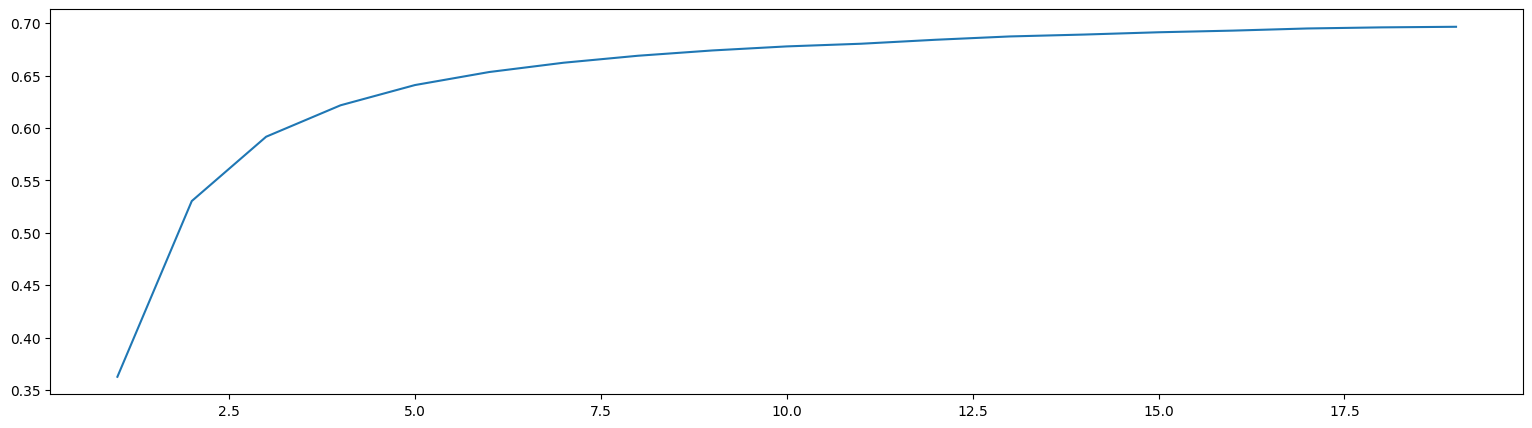

In [133]:
scorel = []
mi = 1
ma = 20
for i in range (mi,ma):
    rfc = RandomForestRegressor(n_estimators=i
                                 ,n_jobs=-1
                                 ,random_state = 0
                                )
    rfc = rfc.fit(X_train,y_train)
    score = rfc.score(X_test,y_test)
#     score = cross_val_score(rfc,Xtest,Ytest,cv=10).mean()
    scorel.append(score)
max_score = max(scorel)
print(max(scorel),scorel.index(max(scorel))+mi)
plt.figure(figsize=[ma-mi,5])
plt.plot(range(mi,ma),scorel)
plt.show()

###     2. max_depth

In [ ]:
scorel = []
mi = 1
ma = 40
for i in range (mi,ma):
    rfc = RandomForestRegressor(n_estimators=10
                                 ,n_jobs=-1
                                 ,random_state = 0
                                ,max_depth=i
                                )
    rfc = rfc.fit(X_train,y_train)
    score = rfc.score(X_test,y_test)
#     score = cross_val_score(rfc,Xtest,Ytest,cv=10).mean()
    scorel.append(score)
print(max(scorel),scorel.index(max(scorel))+mi)
plt.figure(figsize=[ma-mi,5])
plt.plot(range(mi,ma),scorel)
plt.show()

### 3. max_features

In [ ]:
scorel = []
mi = 1
ma = 14
for i in range (mi,ma):
    rfc = RandomForestRegressor(n_estimators=10
                                 ,n_jobs=-1
                                 ,random_state = 0
                                ,max_depth=27
                                ,max_features=i
                                )
    rfc = rfc.fit(X_train,y_train)
    score = rfc.score(X_test,y_test)
#     score = cross_val_score(rfc,Xtest,Ytest,cv=10).mean()
    scorel.append(score)
print(max(scorel),scorel.index(max(scorel))+mi)
plt.figure(figsize=[ma-mi,5])
plt.plot(range(mi,ma),scorel)
plt.show()

### after modify

In [ ]:
rfc = RandomForestRegressor(n_estimators=15
                            ,random_state=0
                            ,max_depth=27
                            ,max_features=7
                           )
rfc = rfc.fit(X_train,y_train)
score = rfc.score(X_test,y_test)
# score = cross_val_score(rfc,Xtest,Ytest,cv=10)
score

In [ ]:
test_prediction = rfc.predict(X_test)
printMetrics(y_test, test_prediction)

In [ ]:
rfc1 = RandomForestRegressor(n_estimators=15
                            ,random_state=0
                            ,max_depth=27
                            ,max_features=7
                           )
rfc1 = rfc1.fit(X_train1,y_train1)
score = rfc1.score(X_test1,y_test1)
# score = cross_val_score(rfc,Xtest,Ytest,cv=10)
score

In [ ]:
test_prediction = rfc1.predict(X_test1)
printMetrics(y_test1, test_prediction)

### Define a function to try to predict few samples in test dataset.

In [ ]:
def myPredict(a,array):
    result = a.predict(array)
    for i in range(len(result)):
        if result[i]-int(result[i])>0.5:
            result[i] = int(result[i])+1
        else:
            result[i]=int(result[i])        
    return result

myPredict(rfc,X_test[0:20])

In [ ]:
y_test[0:20]

In [ ]:
myPredict(rfc1,X_test1[0:20])

In [ ]:
y_test1[0:20]